# Retea CNN  in Pytorch

### Importarea pachetelor necesare 

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.12.1  Device: cpu


In [38]:
!pip install torch-summary

In [39]:
from torchsummary import summary

### Pregatirea setului de date

Setul de date este facut disponibil printr-o clasa de tip `Dataset` specifica Pytorch. Pentru MNIST exista o implementare predefinita. Impartirea setului de date in minibatch-uri este facuta de clasa Pytorch `DataLoader`. 

In [40]:
batch_size = 16

transforms = torchvision.transforms
train_augmentations = transforms.Compose([transforms.RandomGrayscale(0.2),
                                          transforms.RandomHorizontalFlip(0.5),
                                          transforms.RandomVerticalFlip(0.2),
                                          transforms.RandomRotation(30),
                                          transforms.RandomAdjustSharpness(0.4),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                         ])

test_augmentations = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]
                                       )
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=train_augmentations
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=test_augmentations
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

Files already downloaded and verified
Files already downloaded and verified


X_train este mai sus impartit in subseturi de 32 de imagini. Vectorul y_train are valorile claselor (0=cifra 0, ..., 9=cifra 9).

In [41]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([16, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([16]) type: torch.LongTensor


Nota: daca celula de plot produce eroare, atunci se foloseste workaround de la [https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial](https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial):"

In [42]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [43]:
def train(model, optimizer, criterion, train_loader, epoch, device, log_interval=200):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        
        output = model(data)

        loss = criterion(output, target)

        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.data.item():.6f}')

In [44]:
@torch.no_grad()
def validate(model, criterion, validation_loader, device, loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print(f'Validation set: Average loss: {val_loss:.4f}, Accuracy: {correct}/{len(validation_loader.dataset)} ({accuracy:.2f}%)\n')

In [45]:
def plot_scores(lossv, accv):
    figure, axis = plt.subplots(2, 1, figsize=(12, 8))
    figure.tight_layout(pad=5.0)
    axis[0].plot(lossv)
    axis[0].set_title('Loss function on validation subset')
    axis[0].set_xlabel('Epoch')
    axis[0].set_ylabel('Validation Loss')
    
    axis[1].plot(accv)
    axis[1].set_title('Accuracy on validation subset')
    axis[1].set_xlabel('Epoch')
    axis[1].set_ylabel('Validation Acc')
    
    plt.show()

## Retea LeNet5

### Arhitectura retelei

### Definirea retelei

In [46]:
class LeNet5(nn.Module):
    def __init__(self, activation='tanh', pool='avg'):
        super(LeNet5, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2) if pool == 'avg' else nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2) if pool == 'avg' else nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, padding=0)

        self.fc6 = nn.Linear(in_features=480, out_features=84)
        self.fc7 = nn.Linear(in_features=84, out_features=10)
        
        self.activation = nn.Tanh() if activation == 'tanh' else nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.activation(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.activation(x)
        x = self.pool4(x)

        x = self.conv5(x)
        x = self.activation(x)
        
        x = x.view(-1, 480)
        
        x = self.fc6(x)
        x = self.activation(x)
        x = self.fc7(x)

        return x
    
lenet5 = LeNet5()

lenet5.to(device)
optimizer = torch.optim.SGD(lenet5.parameters(), lr=0.0155, momentum=0.85, weight_decay=0.0001)

criterion = nn.CrossEntropyLoss()

print(lenet5)

LeNet5(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv5): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc6): Linear(in_features=480, out_features=84, bias=True)
  (fc7): Linear(in_features=84, out_features=10, bias=True)
  (activation): Tanh()
)


Un sumar al modelului, in special numarul de parametri instruibili este dat mai jos:

In [47]:
summary(lenet5, (3, 32, 32));

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 32, 32]           456
├─Tanh: 1-2                              [-1, 6, 32, 32]           --
├─AvgPool2d: 1-3                         [-1, 6, 16, 16]           --
├─Conv2d: 1-4                            [-1, 16, 12, 12]          2,416
├─Tanh: 1-5                              [-1, 16, 12, 12]          --
├─AvgPool2d: 1-6                         [-1, 16, 6, 6]            --
├─Conv2d: 1-7                            [-1, 120, 2, 2]           48,120
├─Tanh: 1-8                              [-1, 120, 2, 2]           --
├─Linear: 1-9                            [-1, 84]                  40,404
├─Tanh: 1-10                             [-1, 84]                  --
├─Linear: 1-11                           [-1, 10]                  850
Total params: 92,246
Trainable params: 92,246
Non-trainable params: 0
Total mult-adds (M): 1.04
Input size (MB): 0.01
Forward/backward pass si

### Antrenarea retelei LeNet5

In [48]:
%%time
epochs = 50

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(lenet5, optimizer, criterion, train_loader, epoch, device)
    validate(lenet5, criterion, test_loader, device, lossv, accv)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.294745
Train Epoch: 1 [3200/50000 (6%)]	Loss: 1.986377
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.301432
Train Epoch: 1 [9600/50000 (19%)]	Loss: 2.015395
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.087054
Train Epoch: 1 [16000/50000 (32%)]	Loss: 1.912484
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2.084858
Train Epoch: 1 [22400/50000 (45%)]	Loss: 1.380239
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.633193
Train Epoch: 1 [28800/50000 (58%)]	Loss: 1.815570
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.963665
Train Epoch: 1 [35200/50000 (70%)]	Loss: 1.432928
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.497501
Train Epoch: 1 [41600/50000 (83%)]	Loss: 1.872104
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.621335
Train Epoch: 1 [48000/50000 (96%)]	Loss: 2.079720
Validation set: Average loss: 1.6132, Accuracy: 4101/10000 (41.01%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.074852
Train Epoch: 2 [3200/50000 (6%)]	Loss: 1.942978
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.63856

### Grafice evolutie LeNet5

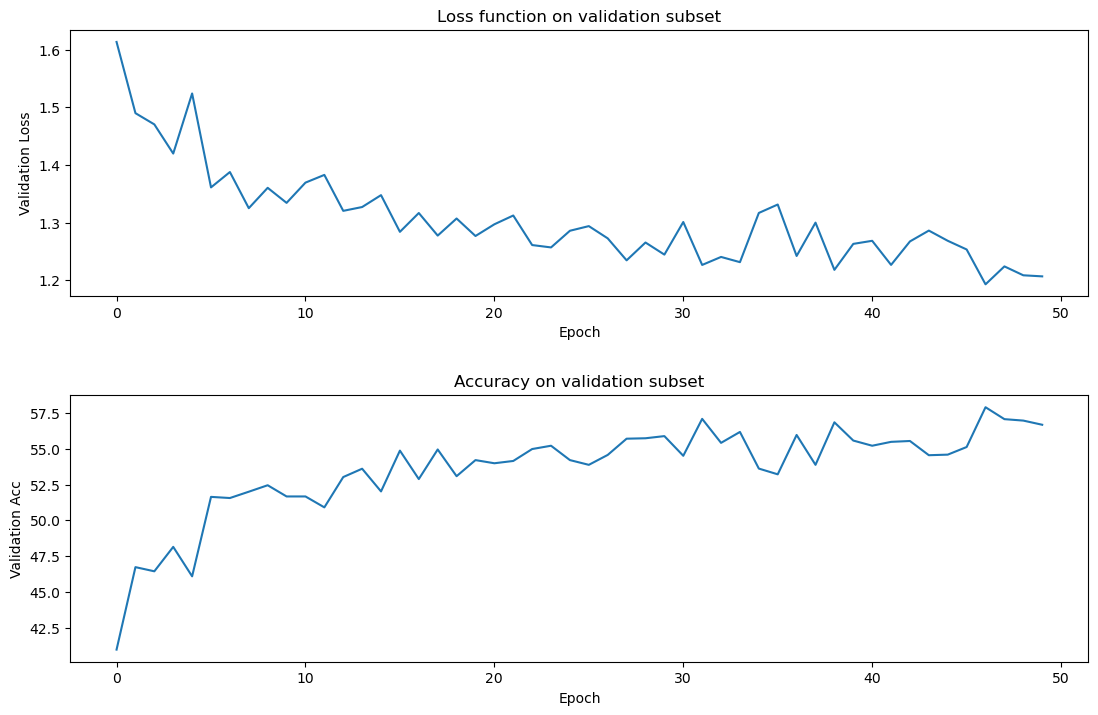

In [49]:
plot_scores(lossv, accv)

### Variatie: LeNet5 cu activare ReLU si max pooling

In [50]:
lenet5_relu = LeNet5(activation='relu', pool='max')

lenet5_relu.to(device)
optimizer = torch.optim.SGD(lenet5_relu.parameters(), lr=0.0105, momentum=0.9)

criterion = nn.CrossEntropyLoss()

print(lenet5_relu)

LeNet5(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc6): Linear(in_features=480, out_features=84, bias=True)
  (fc7): Linear(in_features=84, out_features=10, bias=True)
  (activation): ReLU(inplace=True)
)


Un sumar al modelului, in special numarul de parametri instruibil este dat mai jos:

In [51]:
summary(lenet5_relu, (3, 32, 32));

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 32, 32]           456
├─ReLU: 1-2                              [-1, 6, 32, 32]           --
├─MaxPool2d: 1-3                         [-1, 6, 16, 16]           --
├─Conv2d: 1-4                            [-1, 16, 12, 12]          2,416
├─ReLU: 1-5                              [-1, 16, 12, 12]          --
├─MaxPool2d: 1-6                         [-1, 16, 6, 6]            --
├─Conv2d: 1-7                            [-1, 120, 2, 2]           48,120
├─ReLU: 1-8                              [-1, 120, 2, 2]           --
├─Linear: 1-9                            [-1, 84]                  40,404
├─ReLU: 1-10                             [-1, 84]                  --
├─Linear: 1-11                           [-1, 10]                  850
Total params: 92,246
Trainable params: 92,246
Non-trainable params: 0
Total mult-adds (M): 1.04
Input size (MB): 0.01
Forward/backward pass si

### Antrenarea retelei LeNet5 cu ReLU si max pooling

In [52]:
lenet5_relu.to(device)
optimizer = torch.optim.SGD(lenet5_relu.parameters(), lr=0.01, momentum=0.5)

In [53]:
%%time
epochs = 50

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(lenet5_relu, optimizer, criterion, train_loader, epoch, device)
    validate(lenet5_relu, criterion, test_loader, device, lossv, accv)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.299914
Train Epoch: 1 [3200/50000 (6%)]	Loss: 2.105859
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.136074
Train Epoch: 1 [9600/50000 (19%)]	Loss: 2.216308
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.138958
Train Epoch: 1 [16000/50000 (32%)]	Loss: 1.877005
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2.035547
Train Epoch: 1 [22400/50000 (45%)]	Loss: 1.950502
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.894626
Train Epoch: 1 [28800/50000 (58%)]	Loss: 1.694416
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.500443
Train Epoch: 1 [35200/50000 (70%)]	Loss: 1.776798
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.873418
Train Epoch: 1 [41600/50000 (83%)]	Loss: 1.987465
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.621145
Train Epoch: 1 [48000/50000 (96%)]	Loss: 1.343304
Validation set: Average loss: 1.5387, Accuracy: 4349/10000 (43.49%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.788527
Train Epoch: 2 [3200/50000 (6%)]	Loss: 1.779918
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.80685

### Grafice evolutie LeNet5 cu ReLU si  max pooling

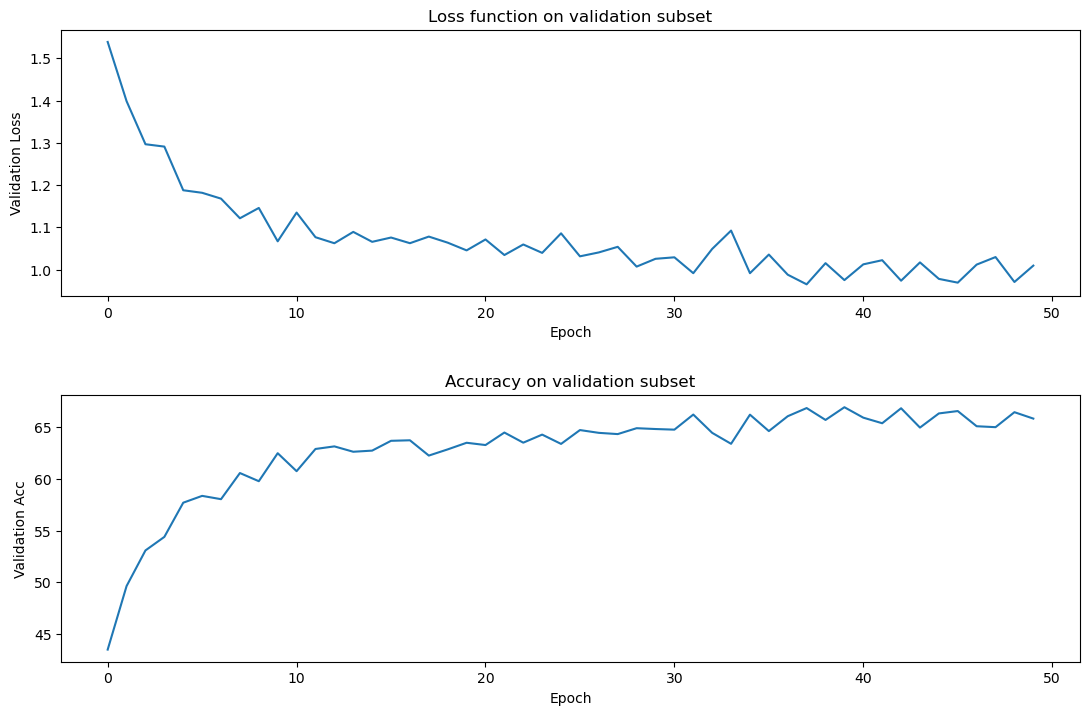

In [54]:
plot_scores(lossv, accv)